# FD001 Branch 4: LSTM-50 하이퍼파라미터 최적화

## 📋 실험 개요

- **Dataset**: FD001
- **Model**: LSTM-50 (window_size=50)
- **Preprocessing**: RUL Clipping (RUL ≤ 125)
- **Scaler**: StandardScaler (Branch 3 최적 결과)
- **실험 목적**: 최적 하이퍼파라미터 탐색

---

## 🎯 튜닝 전략

1. **Random Search**: 넓은 범위 탐색
2. **Manual Grid Search**: 유망 영역 집중 탐색
3. **최종 모델**: 최적 하이퍼파라미터로 재학습

---

## 🔧 튜닝 대상 하이퍼파라미터

- **Learning Rate**: 0.0001 ~ 0.01
- **Batch Size**: 32, 64, 128, 256
- **Dropout Rate**: 0.1 ~ 0.5
- **LSTM Units**: [50-25-10] ~ [200-100-50]
- **Optimizer**: Adam, RMSprop

## 1. 환경 설정 및 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop

import itertools
import time

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

## 2. 데이터 로드 및 전처리

In [2]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 경로 설정
DATA_PATH = '/content/drive/MyDrive/ML project'

# FD001 데이터 로드
train_fd001 = pd.read_csv(f'{DATA_PATH}/FD001_train_df.csv')
test_fd001 = pd.read_csv(f'{DATA_PATH}/FD001_test_df.csv')

In [4]:
# 센서 컬럼 정의
ALL_SENSORS = [f's_{i}' for i in range(1, 22)]

# RUL Clipping
train_preprocessed = train_fd001.copy()
train_preprocessed['RUL'] = train_preprocessed['RUL'].clip(upper=125)

test_preprocessed = test_fd001.copy()
test_preprocessed['RUL'] = test_preprocessed['RUL'].clip(upper=125)

# RobustScaler 적용
scaler = StandardScaler()

train_scaled = train_preprocessed.copy()
train_scaled[ALL_SENSORS] = scaler.fit_transform(train_preprocessed[ALL_SENSORS])

test_scaled = test_preprocessed.copy()
test_scaled[ALL_SENSORS] = scaler.transform(test_preprocessed[ALL_SENSORS])

## 3. 시퀀스 데이터 생성

In [5]:
def create_sequences(df, sensor_cols, window_size=50):
    X, y = [], []

    for unit_id in df['unit'].unique():
        unit_data = df[df['unit'] == unit_id].sort_values('cycle')

        sensor_values = unit_data[sensor_cols].values
        rul_values = unit_data['RUL'].values

        for i in range(len(sensor_values) - window_size + 1):
            X.append(sensor_values[i:i+window_size])
            y.append(rul_values[i+window_size-1])

    return np.array(X), np.array(y)

# 시퀀스 생성
WINDOW_SIZE = 50
X_train, y_train = create_sequences(train_scaled, ALL_SENSORS, WINDOW_SIZE)
X_test, y_test = create_sequences(test_scaled, ALL_SENSORS, WINDOW_SIZE)

# Train/Validation 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=False
)

## 4. LSTM 모델 빌더

In [6]:
def build_lstm_model(input_shape, units=[100, 50, 25], dropout_rate=0.2,
                     learning_rate=0.001, optimizer='adam'):
    model = Sequential([
        LSTM(units[0], input_shape=input_shape, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units[1], return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units[2]),
        Dropout(dropout_rate),
        Dense(1)
    ])

    # Optimizer 선택
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mse', metrics=['mae'])

    return model

## 5. 하이퍼파라미터 튜닝 함수

In [7]:
def train_and_evaluate(params, X_train, y_train, X_val, y_val, X_test, y_test, verbose=0):

    start_time = time.time()

    # 모델 생성
    model = build_lstm_model(
        input_shape=(WINDOW_SIZE, len(ALL_SENSORS)),
        units=params['units'],
        dropout_rate=params['dropout'],
        learning_rate=params['learning_rate'],
        optimizer=params['optimizer']
    )

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=0
    )

    # 학습
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=verbose
    )

    # 예측
    y_train_pred = model.predict(X_train, verbose=0).flatten()
    y_val_pred = model.predict(X_val, verbose=0).flatten()
    y_test_pred = model.predict(X_test, verbose=0).flatten()

    # 평가
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    training_time = time.time() - start_time
    epochs_trained = len(history.history['loss'])

    return {
        'params': params,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'epochs': epochs_trained,
        'training_time': training_time
    }

## 6. Random Search: 넓은 범위 탐색

In [8]:
# Random Search 파라미터 범위
param_distributions = {
    'units': [
        [100, 50, 25],  # Baseline
        [128, 64, 32],
        [150, 75, 35],
        [200, 100, 50],
        [80, 40, 20]
    ],
    'dropout': [0.1, 0.2, 0.3, 0.4],
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
    'batch_size': [64, 128, 256],
    'optimizer': ['adam', 'rmsprop']
}

# Random Search 실행 (10회)
random_search_results = []
n_random_trials = 10

for trial in range(n_random_trials):
    # 랜덤 파라미터 선택 (units는 별도 처리)
    params = {
        'units': param_distributions['units'][np.random.randint(len(param_distributions['units']))],
        'dropout': np.random.choice(param_distributions['dropout']),
        'learning_rate': np.random.choice(param_distributions['learning_rate']),
        'batch_size': np.random.choice(param_distributions['batch_size']),
        'optimizer': np.random.choice(param_distributions['optimizer'])
    }

    # 학습 및 평가
    result = train_and_evaluate(
        params, X_train_split, y_train_split,
        X_val_split, y_val_split, X_test, y_test
    )

    random_search_results.append(result)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

In [9]:
# Random Search 결과 정리
df_random = pd.DataFrame([
    {
        'units': str(r['params']['units']),
        'dropout': r['params']['dropout'],
        'learning_rate': r['params']['learning_rate'],
        'batch_size': r['params']['batch_size'],
        'optimizer': r['params']['optimizer'],
        'val_rmse': r['val_rmse'],
        'test_rmse': r['test_rmse'],
        'test_r2': r['test_r2'],
        'epochs': r['epochs'],
        'time': r['training_time']
    }
    for r in random_search_results
])

# 정렬
df_random_sorted = df_random.sort_values('test_rmse')
df_random_sorted

,units,dropout,learning_rate,batch_size,optimizer,val_rmse,test_rmse,test_r2,epochs,time
8,"[150, 75, 35]",0.4,0.0010,64,adam,13.577972,14.532480,0.785026,45,105.720703
2,"[150, 75, 35]",0.3,0.0050,64,rmsprop,14.144669,15.209653,0.764525,37,81.894470
9,"[80, 40, 20]",0.3,0.0010,64,adam,14.737426,15.578058,0.752979,58,129.730395
4,"[200, 100, 50]",0.2,0.0005,128,rmsprop,15.247703,16.495172,0.723038,67,78.146639
1,"[80, 40, 20]",0.1,0.0010,128,adam,15.337112,16.648548,0.717863,100,119.577964
0,"[200, 100, 50]",0.1,0.0010,256,rmsprop,15.061002,16.998225,0.705887,58,44.470414
7,"[150, 75, 35]",0.3,0.0005,256,rmsprop,19.838322,21.814256,0.515618,100,66.631738
5,"[200, 100, 50]",0.1,0.0001,128,rmsprop,43.705946,51.643483,-1.714801,100,115.187558
6,"[80, 40, 20]",0.4,0.0001,64,adam,52.322204,61.804383,-2.888172,100,218.101891
3,"[150, 75, 35]",0.2,0.0001,128,rmsprop,54.866317,64.765103,-3.269618,100,113.713431


## 7. Grid Search: 유망 영역 집중 탐색

In [10]:
# Random Search 결과를 바탕으로 Grid Search 범위 설정
# TODO: Random Search 결과 확인 후 범위 조정

# 예시: Random Search에서 좋았던 범위를 좁혀서 탐색
best_random = random_search_results[df_random_sorted.index[0]]

# Grid Search 파라미터 (좁은 범위)
grid_params = {
    'units': [best_random['params']['units']],  # 고정 or 주변 값
    'dropout': [0.1, 0.2, 0.3],  # 주변 값 탐색
    'learning_rate': [0.0005, 0.001, 0.002],  # 주변 값 탐색
    'batch_size': [64, 128],  # 주변 값 탐색
    'optimizer': [best_random['params']['optimizer']]  # 고정
}

# Grid 조합 생성
grid_combinations = list(itertools.product(
    grid_params['units'],
    grid_params['dropout'],
    grid_params['learning_rate'],
    grid_params['batch_size'],
    grid_params['optimizer']
))

grid_search_results = []

for idx, (units, dropout, lr, batch, opt) in enumerate(grid_combinations):
    params = {
        'units': units,
        'dropout': dropout,
        'learning_rate': lr,
        'batch_size': batch,
        'optimizer': opt
    }

    result = train_and_evaluate(
        params, X_train_split, y_train_split,
        X_val_split, y_val_split, X_test, y_test
    )

    grid_search_results.append(result)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

In [11]:
# Grid Search 결과 정리
df_grid = pd.DataFrame([
    {
        'dropout': r['params']['dropout'],
        'learning_rate': r['params']['learning_rate'],
        'batch_size': r['params']['batch_size'],
        'val_rmse': r['val_rmse'],
        'test_rmse': r['test_rmse'],
        'test_r2': r['test_r2']
    }
    for r in grid_search_results
])

df_grid_sorted = df_grid.sort_values('test_rmse')
df_grid_sorted

,dropout,learning_rate,batch_size,val_rmse,test_rmse,test_r2
15,0.3,0.0010,128,13.094643,14.155423,0.796036
11,0.2,0.0020,128,12.873449,14.288329,0.792188
2,0.1,0.0010,64,13.146591,14.396787,0.789022
3,0.1,0.0010,128,13.356400,14.602396,0.782952
16,0.3,0.0020,64,13.293831,14.641365,0.781792
4,0.1,0.0020,64,13.710994,14.685906,0.780463
10,0.2,0.0020,64,12.503469,14.687028,0.780429
6,0.2,0.0005,64,14.719900,14.744705,0.778701
5,0.1,0.0020,128,14.024203,14.764397,0.778110
17,0.3,0.0020,128,12.775147,14.786389,0.777448


## 8. 최적 하이퍼파라미터 선택 및 최종 모델

In [12]:
# 전체 결과 통합
all_results = random_search_results + grid_search_results
best_result = min(all_results, key=lambda x: x['test_rmse'])

lines = [
    "=" * 70,
    "최적 하이퍼파라미터",
    "=" * 70
]

exclude = {'random_state', 'n_jobs', 'verbose'}
lines.extend([
    f"{k.replace('_', ' ').title()}: {v}"
    for k, v in best_result['params'].items()
    if k not in exclude
])

# 성능 지표
lines.extend([
    "",
    "=" * 70,
    "최고 성능",
    "=" * 70,
    f"Train RMSE: {best_result['train_rmse']:.2f}",
    f"Val RMSE: {best_result['val_rmse']:.2f}",
    f"Test RMSE: {best_result['test_rmse']:.2f}",
    f"Test MAE: {best_result['test_mae']:.2f}",
    f"Test R²: {best_result['test_r2']:.4f}",
    f"Epochs: {best_result['epochs']}",
    f"Training Time: {best_result['training_time']:.1f}s"
])

print("\n".join(lines))

최적 하이퍼파라미터
Units: [150, 75, 35]
Dropout: 0.3
Learning Rate: 0.001
Batch Size: 128
Optimizer: adam

최고 성능
Train RMSE: 7.65
Val RMSE: 13.09
Test RMSE: 14.16
Test MAE: 10.93
Test R²: 0.7960
Epochs: 83
Training Time: 102.6s


## 9. 결과 시각화

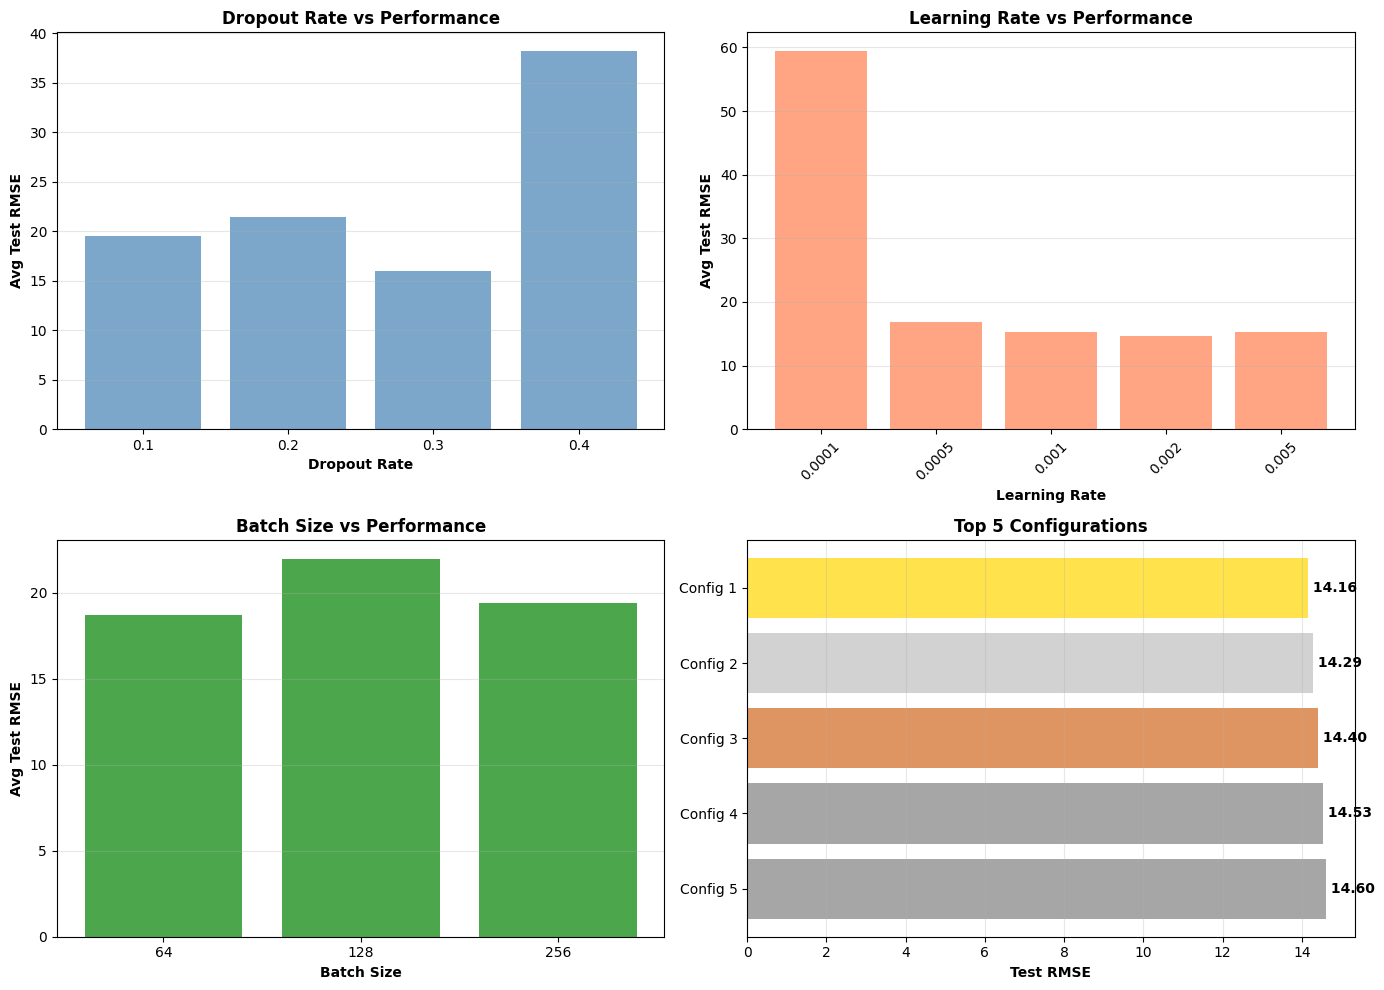

In [13]:
# 하이퍼파라미터별 성능 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 전체 결과 DataFrame
df_all = pd.DataFrame([
    {
        'dropout': r['params']['dropout'],
        'learning_rate': r['params']['learning_rate'],
        'batch_size': r['params']['batch_size'],
        'test_rmse': r['test_rmse']
    }
    for r in all_results
])

# 1. Dropout vs RMSE
ax1 = axes[0, 0]
dropout_avg = df_all.groupby('dropout')['test_rmse'].mean()
ax1.bar(dropout_avg.index.astype(str), dropout_avg.values, color='steelblue', alpha=0.7)
ax1.set_xlabel('Dropout Rate', fontweight='bold')
ax1.set_ylabel('Avg Test RMSE', fontweight='bold')
ax1.set_title('Dropout Rate vs Performance', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. Learning Rate vs RMSE
ax2 = axes[0, 1]
lr_avg = df_all.groupby('learning_rate')['test_rmse'].mean()
ax2.bar(lr_avg.index.astype(str), lr_avg.values, color='coral', alpha=0.7)
ax2.set_xlabel('Learning Rate', fontweight='bold')
ax2.set_ylabel('Avg Test RMSE', fontweight='bold')
ax2.set_title('Learning Rate vs Performance', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Batch Size vs RMSE
ax3 = axes[1, 0]
batch_avg = df_all.groupby('batch_size')['test_rmse'].mean()
ax3.bar(batch_avg.index.astype(str), batch_avg.values, color='green', alpha=0.7)
ax3.set_xlabel('Batch Size', fontweight='bold')
ax3.set_ylabel('Avg Test RMSE', fontweight='bold')
ax3.set_title('Batch Size vs Performance', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Top 5 Configurations
ax4 = axes[1, 1]
top5 = sorted(all_results, key=lambda x: x['test_rmse'])[:5]
config_names = [f"Config {i+1}" for i in range(5)]
rmse_values = [r['test_rmse'] for r in top5]
colors = ['gold' if i == 0 else 'silver' if i == 1 else 'chocolate' if i == 2 else 'gray'
          for i in range(5)]
ax4.barh(config_names, rmse_values, color=colors, alpha=0.7)
ax4.set_xlabel('Test RMSE', fontweight='bold')
ax4.set_title('Top 5 Configurations', fontweight='bold')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

for i, (name, val) in enumerate(zip(config_names, rmse_values)):
    ax4.text(val, i, f' {val:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()